In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
steubk_wikiart_path = kagglehub.dataset_download('steubk/wikiart')
bambii21_genres_ds_path = kagglehub.dataset_download('bambii21/genres-ds')
samamostafa03_style_ds_path = kagglehub.dataset_download('samamostafa03/style-ds')

print('Data source import complete.')

100%|██████████| 31.4G/31.4G [03:25<00:00, 163MB/s]

Extracting files...


100%|██████████| 1.13M/1.13M [00:00<00:00, 140MB/s]

Extracting files...


100%|██████████| 1.42M/1.42M [00:00<00:00, 153MB/s]

Extracting files...
Data source import complete.


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import ops
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, get_worker_info
import timm
from timm.data import Mixup
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from tqdm.notebook import tqdm
import gc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate
import itertools
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import accuracy_score,roc_curve,auc
from sklearn.preprocessing import label_binarize
from PIL import Image
sns.set(style='white', context='notebook', palette='deep')

In [ ]:
# prompt: open the directory and check the data from the path above


def check_kaggle_data(path):
  """Checks if the directory exists and prints its contents."""

  if os.path.exists(path):
    print(f"Directory '{path}' exists.")
    try:
      for filename in os.listdir(path):
          filepath = os.path.join(path, filename)
          if os.path.isfile(filepath):
              print(f"  File: {filename}")
          elif os.path.isdir(filepath):
              print(f"  Directory: {filename}")
    except PermissionError:
      print(f"Permission denied when accessing '{path}'.")
    except OSError as e:
      print(f"Error accessing '{path}': {e}")
  else:
    print(f"Directory '{path}' does not exist.")

# Assuming kagglehub.dataset_download returns the correct path
#  and that the provided code was executed successfully in a previous cell.


check_kaggle_data(steubk_wikiart_path)
check_kaggle_data(bambii21_genres_ds_path)
check_kaggle_data(samamostafa03_style_ds_path)


Directory '/root/.cache/kagglehub/datasets/steubk/wikiart/versions/1' exists.
  Directory: Realism
  File: wclasses.csv
  Directory: Art_Nouveau_Modern
  File: classes.csv
  Directory: Action_painting
  Directory: Color_Field_Painting
  Directory: Fauvism
  Directory: Mannerism_Late_Renaissance
  Directory: Ukiyo_e
  Directory: New_Realism
  Directory: Romanticism
  Directory: Pointillism
  Directory: Analytical_Cubism
  Directory: Expressionism
  Directory: Pop_Art
  Directory: Minimalism
  Directory: High_Renaissance
  Directory: Post_Impressionism
  Directory: Symbolism
  Directory: Northern_Renaissance
  Directory: Baroque
  Directory: Contemporary_Realism
  Directory: Early_Renaissance
  Directory: Naive_Art_Primitivism
  Directory: Impressionism
  Directory: Abstract_Expressionism
  Directory: Synthetic_Cubism
  Directory: Rococo
  Directory: Cubism
Directory '/root/.cache/kagglehub/datasets/bambii21/genres-ds/versions/1' exists.
  File: genre_val.csv
  File: genre_train.csv
  Fi

In [ ]:
# Load and map genres, styles classes
datapath = steubk_wikiart_path
genres_datapath = bambii21_genres_ds_path
styles_datapath = samamostafa03_style_ds_path

In [ ]:
def process_classes(data_path,file_name):
    file_path =  data_path+'/'+file_name+'.txt'
    classes = {}
    with open(file_path, 'r') as f:
        for line in f:
            index, label = line.strip().split(' ', 1)
            classes[int(index)] = label
    return classes

genres_classes = process_classes(genres_datapath, 'genre_class')
styles_classes = process_classes(styles_datapath,'style_class')
print(f"Genres:\n{genres_classes}\n")
print(f"Styles:\n{styles_classes}")

Genres:
{0: 'abstract_painting', 1: 'cityscape', 2: 'genre_painting', 3: 'illustration', 4: 'landscape', 5: 'nude_painting', 6: 'portrait', 7: 'religious_painting', 8: 'sketch_and_study', 9: 'still_life'}

Styles:
{0: 'Abstract_Expressionism', 1: 'Action_painting', 2: 'Analytical_Cubism', 3: 'Art_Nouveau', 4: 'Baroque', 5: 'Color_Field_Painting', 6: 'Contemporary_Realism', 7: 'Cubism', 8: 'Early_Renaissance', 9: 'Expressionism', 10: 'Fauvism', 11: 'High_Renaissance', 12: 'Impressionism', 13: 'Mannerism_Late_Renaissance', 14: 'Minimalism', 15: 'Naive_Art_Primitivism', 16: 'New_Realism', 17: 'Northern_Renaissance', 18: 'Pointillism', 19: 'Pop_Art', 20: 'Post_Impressionism', 21: 'Realism', 22: 'Rococo', 23: 'Romanticism', 24: 'Symbolism', 25: 'Synthetic_Cubism', 26: 'Ukiyo_e'}


In [ ]:
# Load train and validation data
genre_data_valid = pd.read_csv(genres_datapath+'/genre_val.csv')
genre_data_train = pd.read_csv(genres_datapath+'/genre_train.csv')
genre_data_train.head()

,filename,genre
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3
2,Expressionism/martiros-saryan_mother-of-the-ar...,6
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6


In [ ]:
style_data_valid = pd.read_csv(
    styles_datapath + '/style_val.csv',
    header=None,
    names=['filename', 'style']
)
style_data_train = pd.read_csv(
    styles_datapath + '/style_train.csv',
    header=None,
    names=['filename', 'style']
)
style_data_train.head()

,filename,style
0,Impressionism/edgar-degas_landscape-on-the-orn...,12
1,Realism/camille-corot_mantes-cathedral.jpg,21
2,Abstract_Expressionism/gene-davis_untitled-197...,0
3,Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg,24
4,Impressionism/maurice-prendergast_paris-boulev...,12


In [ ]:
# Merge datasets on filename (assuming filenames are unique and match)
data_train = pd.merge(genre_data_train, style_data_train, on='filename', suffixes=('_genre', '_style'))
data_valid = pd.merge(genre_data_valid , style_data_valid , on='filename', suffixes=('_genre', '_style'))
data_train.head()

,filename,genre,style
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4,20
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3,24
2,Expressionism/martiros-saryan_mother-of-the-ar...,6,9
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6,9


In [ ]:
# Check for missing values
print(f"train:\n{data_train.isnull().sum()}\n")
print(f"validation:\n{data_valid.isnull().sum()}")

train:
filename    0
genre       0
style       0
dtype: int64

validation:
filename    0
genre       0
style       0
dtype: int64


In [ ]:
# Identify invalid filenames
def find_invalid_filenames(dataframe, base_dir):
    invalid_files = []
    for filename in dataframe['filename']:
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

invalid_filenames_train = find_invalid_filenames(data_train, datapath)
invalid_filenames_valid = find_invalid_filenames(data_valid, datapath)

print(f"Number of invalid files in train data: {len(invalid_filenames_train)}")
print(f"Number of invalid files in valid data: {len(invalid_filenames_valid)}")

Number of invalid files in train data: 421
Number of invalid files in valid data: 191


In [ ]:
# Remove invalid filenames from both train and validation datasets
data_train_cleaned = data_train[~data_train['filename'].isin(invalid_filenames_train)]
print(f"Number of valid rows in train after cleaning: {len(data_train_cleaned)}")

data_valid_cleaned = data_valid[~data_valid['filename'].isin(invalid_filenames_valid)]
print(f"Number of valid rows in valid after cleaning: {len(data_valid_cleaned)}")

Number of valid rows in train after cleaning: 44868
Number of valid rows in valid after cleaning: 19149


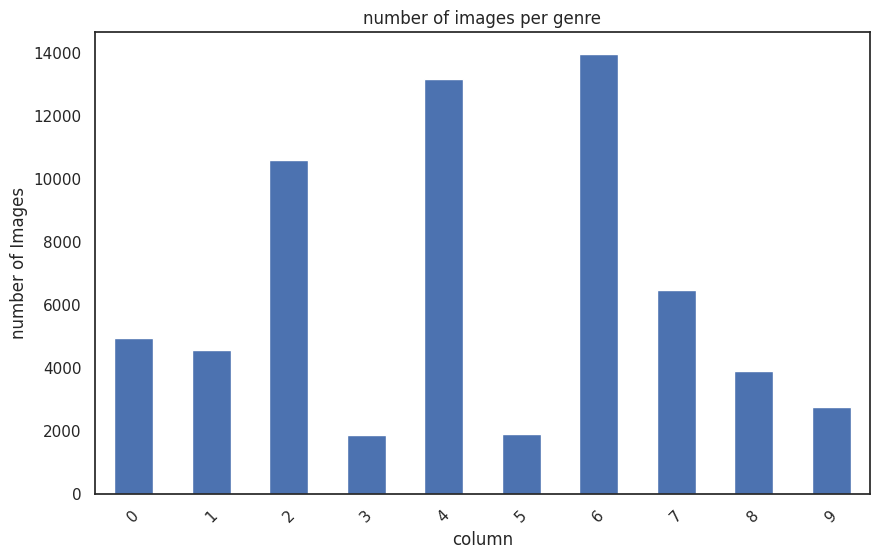

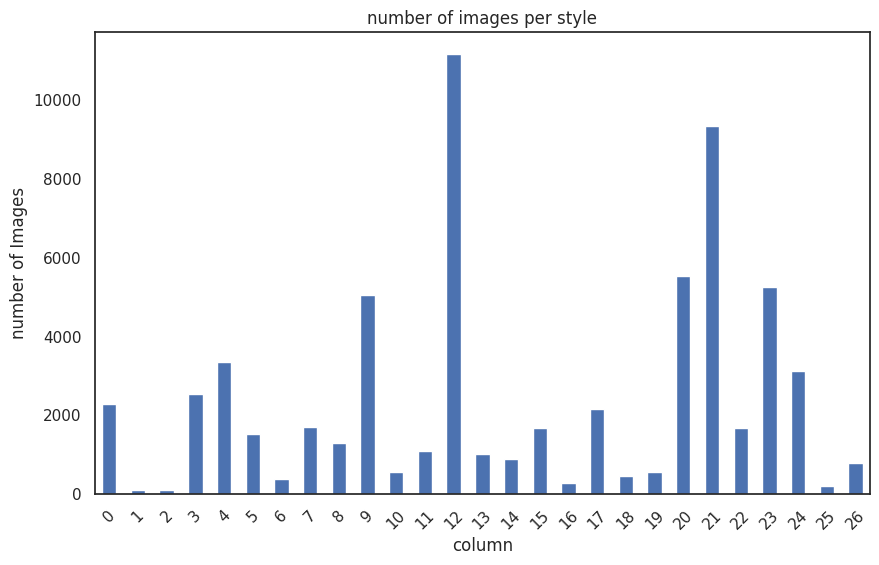

In [ ]:
# Visualize the genres , styles distribution
def visualize_data(data_train,data_val,column,classes):
    combined_data = (data_train_cleaned[column].value_counts() + data_valid_cleaned[column].value_counts())
    combined_data.sort_index().plot(kind='bar', figsize=(10, 6), legend=False)
    plt.title(f"number of images per {column}")
    plt.ylabel("number of Images")
    plt.xlabel('column')
    plt.xticks(rotation=45)
    plt.show()
visualize_data(data_train_cleaned,data_valid_cleaned,'genre',genres_classes)
visualize_data(data_train_cleaned,data_valid_cleaned,'style',styles_classes)

In [ ]:
# Extract features and labels
train_images = data_train_cleaned["filename"].values
genre_train_labels = data_train_cleaned["genre"].values
style_train_labels = data_train_cleaned["style"].values

valid_images = data_valid_cleaned["filename"].values
genre_valid_labels = data_valid_cleaned["genre"].values
style_valid_labels = data_valid_cleaned["style"].values

In [ ]:
# prompt: convert to pytorch dataset

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class WikiArtDataset(Dataset):
    def __init__(self, images, genre_labels, style_labels, root_dir, transform=None):
        self.images = images
        self.genre_labels = genre_labels
        self.style_labels = style_labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')
        genre_label = self.genre_labels[idx]
        style_label = self.style_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, genre_label, style_label


# Example usage (assuming you have defined 'datapath', 'train_images', 'genre_train_labels', etc.):
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a suitable input size for your model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

train_dataset = WikiArtDataset(train_images, genre_train_labels, style_train_labels, datapath, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Adjust batch_size as needed

#Similarly create validation dataset and dataloader
valid_dataset = WikiArtDataset(valid_images, genre_valid_labels, style_valid_labels, datapath, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False) # No need to shuffle validation data


In [ ]:
# prompt: use the pytorch data above to train a ResNet model that classify genre, add training accuracy and loss for each epoch, include validation part

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm.notebook import tqdm

# Assuming train_loader and valid_loader are defined as in the previous code

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Modify the classifier for genre classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(set(genre_train_labels))) # Number of genre classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 6 # You can adjust the number of epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, genre_labels, _ in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        images = images.to(device)
        genre_labels = torch.tensor(genre_labels, dtype=torch.long).to(device)  # Convert labels to LongTensor

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, genre_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_predictions += genre_labels.size(0)
        correct_predictions += (predicted == genre_labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_predictions / total_predictions

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    #Validation
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():
      for val_images, val_genre_labels, _ in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
          val_images = val_images.to(device)
          val_genre_labels = torch.tensor(val_genre_labels, dtype=torch.long).to(device)

          val_outputs = model(val_images)
          val_loss = criterion(val_outputs, val_genre_labels)

          val_running_loss += val_loss.item() * val_images.size(0)
          _, val_predicted = torch.max(val_outputs, 1)
          val_total_predictions += val_genre_labels.size(0)
          val_correct_predictions += (val_predicted == val_genre_labels).sum().item()

      val_epoch_loss = val_running_loss / len(valid_dataset)
      val_epoch_acc = val_correct_predictions / val_total_predictions
      print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}")


print("Finished Training")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


Epoch 1/6 - Training:   0%|          | 0/1403 [00:00<?, ?it/s]

<ipython-input-15-c63287bade3f>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  genre_labels = torch.tensor(genre_labels, dtype=torch.long).to(device)  # Convert labels to LongTensor


Epoch 1/6, Training Loss: 1.2413, Training Accuracy: 0.5750


Epoch 1/6 - Validation:   0%|          | 0/599 [00:00<?, ?it/s]

<ipython-input-15-c63287bade3f>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_genre_labels = torch.tensor(val_genre_labels, dtype=torch.long).to(device)


Epoch 1/6, Validation Loss: 1.2093, Validation Accuracy: 0.5796


Epoch 2/6 - Training:   0%|          | 0/1403 [00:00<?, ?it/s]

Epoch 2/6, Training Loss: 1.0004, Training Accuracy: 0.6545


Epoch 2/6 - Validation:   0%|          | 0/599 [00:00<?, ?it/s]

Epoch 2/6, Validation Loss: 0.9733, Validation Accuracy: 0.6681


Epoch 3/6 - Training:   0%|          | 0/1403 [00:00<?, ?it/s]

Epoch 3/6, Training Loss: 0.8972, Training Accuracy: 0.6894


Epoch 3/6 - Validation:   0%|          | 0/599 [00:00<?, ?it/s]

Epoch 3/6, Validation Loss: 1.0287, Validation Accuracy: 0.6513


Epoch 4/6 - Training:   0%|          | 0/1403 [00:00<?, ?it/s]

Epoch 4/6, Training Loss: 0.8301, Training Accuracy: 0.7130


Epoch 4/6 - Validation:   0%|          | 0/599 [00:00<?, ?it/s]

Epoch 4/6, Validation Loss: 0.9373, Validation Accuracy: 0.6782


Epoch 5/6 - Training:   0%|          | 0/1403 [00:00<?, ?it/s]

Epoch 5/6, Training Loss: 0.7520, Training Accuracy: 0.7385


Epoch 5/6 - Validation:   0%|          | 0/599 [00:00<?, ?it/s]

Epoch 5/6, Validation Loss: 0.9212, Validation Accuracy: 0.6861


Epoch 6/6 - Training:   0%|          | 0/1403 [00:00<?, ?it/s]

Epoch 6/6, Training Loss: 0.6699, Training Accuracy: 0.7667


Epoch 6/6 - Validation:   0%|          | 0/599 [00:00<?, ?it/s]

Epoch 6/6, Validation Loss: 0.9229, Validation Accuracy: 0.6900
Finished Training


In [ ]:
#Save the model
torch.save(model.state_dict(), 'resnet50_genre.pth')

In [ ]:
import matplotlib.pyplot as plt

train_L = [1.2724, 1.0177, 0.9079, 0.8367, 0.7641, 0.6856, 0.5973, 0.5015, 0.4025, 0.3092]
train_A = [0.5621, 0.6495, 0.6857, 0.7106, 0.7328, 0.7614, 0.7897, 0.8249, 0.8584, 0.8908]

val_L = [1.2037, 1.0015, 0.9836, 1.0279, 0.9822, 0.8752, 0.9295, 0.9896, 1.0103, 1.1277]
val_A = [0.5967, 0.6565, 0.6582, 0.6594, 0.6676, 0.7094, 0.6979, 0.6873, 0.6983, 0.6856]

epoch = [x for x in range(1, 11)]

epoch

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

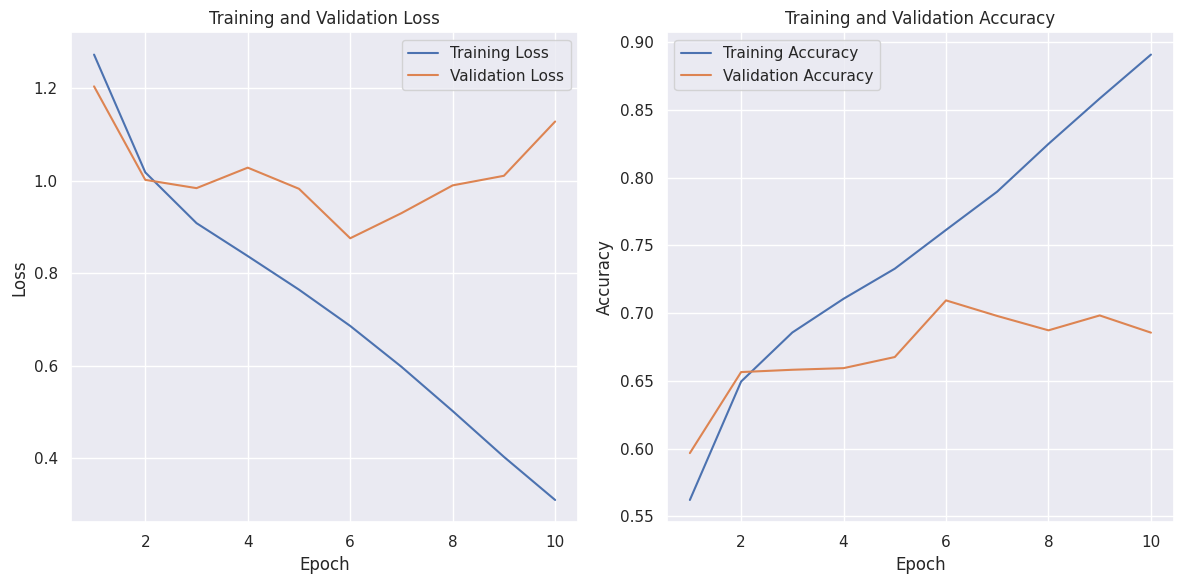

In [ ]:
import seaborn as sns

sns.set(font_scale=1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch, train_L, label='Training Loss')
plt.plot(epoch, val_L, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch, train_A, label='Training Accuracy')
plt.plot(epoch, val_A, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the model
model_path = "/content/drive/MyDrive/resnet50_genre.pth" # Replace with the actual path to your model file
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture
model = models.resnet50(num_classes=10)

# Load the saved state dictionary into the model
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

model.to(device)

model.eval() # Set the model to evaluation mode # Now this line should work

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

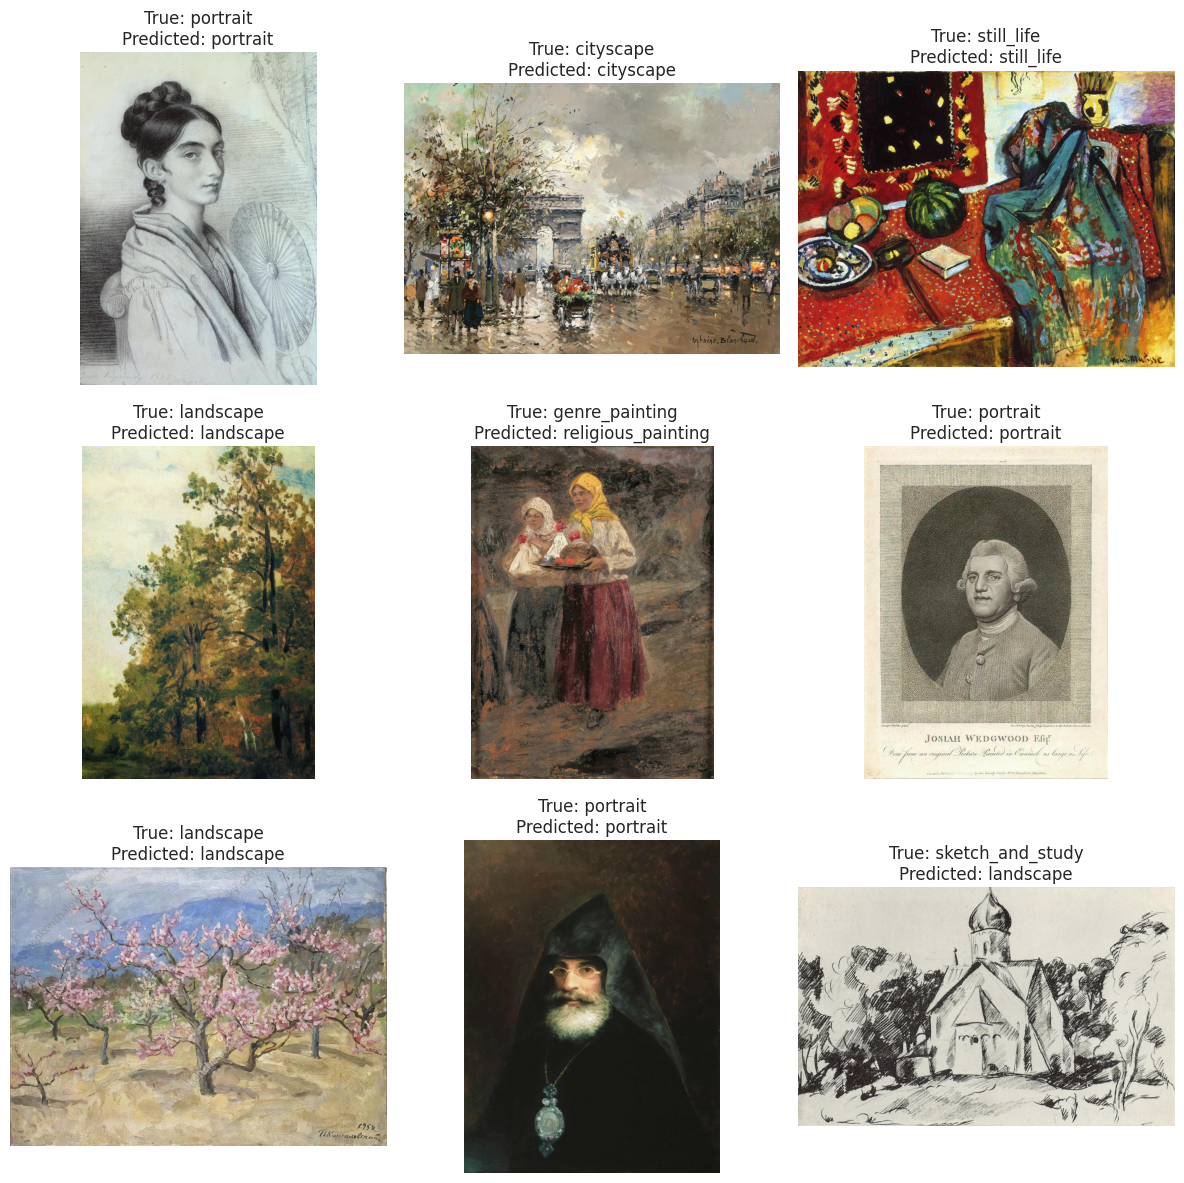

In [ ]:
# prompt: use this model to create 9 samples' visualization (randomly select 9 samples), 3*3, with true and predicted labels, using the data above

import random
import matplotlib.pyplot as plt
from PIL import Image

# Assuming valid_loader, model, device, and genres_classes are defined as in the previous code

# Select 9 random samples from the validation set
num_samples = 9
random_indices = random.sample(range(len(valid_dataset)), num_samples)

# Create a figure and axes for the subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Iterate through the selected samples and display them
for i, index in enumerate(random_indices):
    image, genre_label, _ = valid_dataset[index]
    image = image.unsqueeze(0).to(device) # Add batch dimension and move to device

    with torch.no_grad():
      outputs = model(image)

    _, predicted = torch.max(outputs, 1)
    predicted_label = predicted.item()

    #Get the image path
    image_path = os.path.join(datapath, valid_dataset.images[index])

    #Display image
    img = mpimg.imread(image_path)
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(f"True: {genres_classes[genre_label]}\nPredicted: {genres_classes[predicted_label]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("1.jpg")
plt.show()
